In [1]:
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt

In [2]:
from pbcpy.base import Cell
from pbcpy.grid import Grid
#

In [3]:
from pbcpy.grid_functions import Grid_Function_Base, Grid_Function, Grid_Function_Reciprocal, Grid_Space

In [4]:
from pbcpy.functionals import Functional

In [5]:
from pbcpy.nonlocal_functionals_utils import LindhardFunction, MGP_kernel, WT_kernel

In [6]:
from pbcpy.local_functionals_utils import ThomasFermiEnergy, ThomasFermiPotential
from pbcpy.local_functionals_utils import vonWeizsackerEnergy, vonWeizsackerPotential

In [7]:
from pbcpy.formats.qepp import PP
from pbcpy.formats.xsf import XSF

In [8]:
mol = PP(filepp='Al_fde_rho.pp').read()

In [9]:
density = mol.plot

In [10]:
grid_real             = Grid_Space(density.grid.at,density.grid.nr)
dens_real_space       = Grid_Function(grid_real,griddata_3d=density.values)

# Local and Semilocal Functionals energy and potential

In [11]:
ThomasFermi = Functional(energydensity=ThomasFermiEnergy(dens_real_space),
                         potential=ThomasFermiPotential(dens_real_space))

In [12]:
vonWeizsacker = Functional(energydensity=vonWeizsackerEnergy(dens_real_space,SmoothingFactor=0.05),
                           potential=vonWeizsackerPotential(dens_real_space,SmoothingFactor=0.05))

In [13]:
GEA2 = Functional(energydensity=ThomasFermiEnergy(dens_real_space).sum(
                      vonWeizsackerEnergy(dens_real_space).dot(g=1.0/9.0)),
                  potential=ThomasFermiPotential(dens_real_space).sum(
                      vonWeizsackerPotential(dens_real_space).dot(g=1.0/9.0)))

In [14]:
TFvW = Functional(energydensity=ThomasFermiEnergy(dens_real_space).sum(
                      vonWeizsackerEnergy(dens_real_space)),
                  potential=ThomasFermiPotential(dens_real_space).sum(
                      vonWeizsackerPotential(dens_real_space)))

# Nonlocal Functionals energy and potential

In [15]:
dens_real_space.integral()/mol.cell.omega

0.026847694907688513

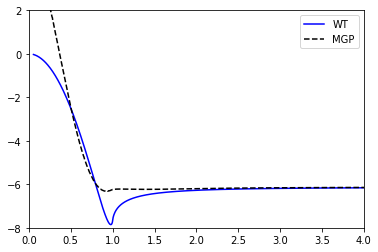

In [16]:
#
# Cute-looking kernels
#
q=np.linspace(0.1,8,1000)
gmpker = MGP_kernel(q,dens_real_space.integral()/mol.cell.omega,0.3,500)
wtker = WT_kernel(q,dens_real_space.integral()/mol.cell.omega)
eta = q/(2.0 * (3.0 * dens_real_space.integral()/mol.cell.omega * np.pi**2)**(1.0/3.0))
plt.plot(eta,wtker,color='blue',label='WT')
plt.plot(eta,gmpker,label='MGP',color='black',linestyle='--')
plt.xlim(0,4)
plt.ylim(-8,2)
plt.legend()
plt.savefig("./kernels_comparison.pdf")
plt.show()

In [17]:
rho0=dens_real_space.integral()/mol.cell.omega
q = grid_real.reciprocal_grid.dist_values()

In [18]:
wtker = WT_kernel(q,rho0)

In [19]:
WTdens = dens_real_space.energy_density(kernel=wtker,a=(5.0/6.0),b=(5.0/6.0),c=1.0)
WTpot = dens_real_space.energy_potential(kernel=wtker,a=(5.0/6.0),c=1.0)
WTpotential = Grid_Function(dens_real_space.grid_space,griddata_3d=(5.0/6.0)*2.0*WTpot.values*dens_real_space.values**(5.0/6.0-1.0))

In [20]:
WT_Functional = Functional( 
    energydensity=WTdens.sum(vonWeizsacker.energydensity.sum(ThomasFermi.energydensity)), \
    potential=WTpotential.sum(vonWeizsacker.potential.sum(ThomasFermi.potential)),kernel=wtker)

In [21]:
#MGPker = MGP_kernel(q,rho0,0.03,400)
MGPker = wtker

In [22]:
MGPdens = dens_real_space.energy_density(kernel=MGPker,a=(5.0/6.0),b=(5.0/6.0),c=1.0)
MGPpot = dens_real_space.energy_potential(kernel=MGPker,a=(5.0/6.0),c=1.0)
MGPpotential = Grid_Function(dens_real_space.grid_space,griddata_3d=(5.0/6.0)*2.0*MGPpot.values*dens_real_space.values**(5.0/6.0-1.0))

In [23]:
MGP_Functional = Functional( 
    energydensity=MGPdens.sum(vonWeizsacker.energydensity.sum(ThomasFermi.energydensity)), \
    potential=MGPpotential.sum(vonWeizsacker.potential.sum(ThomasFermi.potential)),kernel=MGPker)

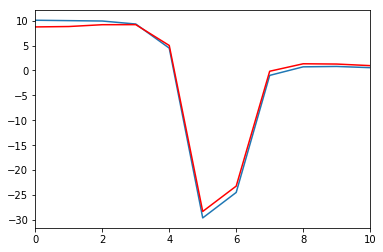

In [24]:
#plt.plot(ThomasFermi.potential.values[:,0,0])
plt.plot(vonWeizsacker.potential.values[:,0,0])
#plt.plot(GEA2.potential.values[:,0,0],c='black')
plt.plot(WT_Functional.potential.values[:,0,0],c='red')
#plt.plot(MGP_Functional.potential.values[:,0,0]-WT_Functional.potential.values[:,0,0],c='black')
plt.xlim(0,10)
#plt.ylim(-0.2,0.5)
plt.show()

In [25]:
print(['WT','MGP','GEA2','TF+vW','TF','vW'])
print (27.211385*np.array([WT_Functional.energydensity.integral(),MGP_Functional.energydensity.integral(),GEA2.energydensity.integral(),TFvW.energydensity.integral(),ThomasFermi.energydensity.integral(),vonWeizsacker.energydensity.integral()]))

['WT', 'MGP', 'GEA2', 'TF+vW', 'TF', 'vW']
[ 80.52358423  80.52358423  49.94310407  97.37854154  44.01367439
  41.99820874]


# Hartree energy and potential

In [26]:
f=q.copy()
f[np.where(q != 0)] = 4*np.pi/q[np.where(q != 0)]**2

In [27]:
Hartree = Functional(energydensity=dens_real_space.energy_density(kernel=f,a=1.0,b=1.0,c=1.0),potential=dens_real_space.energy_potential(kernel=f,a=1.0,c=1.0),kernel=f)

In [36]:
Hartree.energydensity.integral()

0.014359418230940422

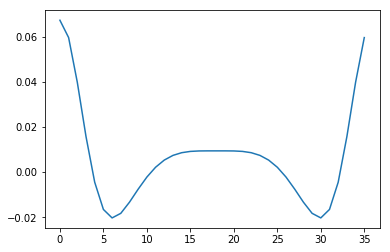

In [29]:
plt.plot(Hartree.potential.values[:,0,0])
plt.show()

# $E_{Nel}$ energy and potential

In [31]:
natoms=np.shape(mol.ions)[0]

In [32]:
NuclearElectron = mol.ions[0].Get_eN_Interaction(grid_space=grid_real,rho=dens_real_space,outfile='./Al_lda.oe01.recpot')
for i in range(1,natoms,1):
    eN_tmp = mol.ions[i].Get_eN_Interaction(grid_space=grid_real,rho=dens_real_space,outfile='./Al_lda.oe01.recpot')
    NuclearElectron = NuclearElectron.sum(eN_tmp)

Recpot pseudopotential ./Al_lda.oe01.recpot loaded
Recpot pseudopotential ./Al_lda.oe01.recpot loaded


In [33]:
NuclearElectron.energydensity.integral()

-4.1318848457810287

In [34]:
TF_TotalEnergy = ThomasFermi.sum(NuclearElectron).sum(Hartree)

In [35]:
TF_TotalEnergy.energydensity.integral()

-2.5000526531841003

In [76]:
27.211385*(ThomasFermi.energydensity.integral()+Hartree.energydensity.integral()+NuclearElectron.energydensity.integral())

-11.830222149392036

In [ ]:
E0 = 